### **Library Imports**

In [1]:
import os
import re
import cv2
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
from torchvision import models, transforms

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

### **Utilities and Constants**

In [2]:
le = LabelEncoder()

SEED = 42
SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRANSFORM_FINAL = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
TRANSFORM = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.35131, 0.37479, 0.28713], [0.15393, 0.15815, 0.12275])])

SAVE_PATH = "saves"
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [3]:
def breaker(num: int = 50, char: str = "*") -> None:
    print("\n" + num*char + "\n")


def show_graphs(L: list, A: list) -> None:
    TL, VL, TA, VA = [], [], [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.subplot(1, 2, 2)
    plt.plot(x_Axis, TA, "r", label="Train")
    plt.plot(x_Axis, VA, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Accuracy Graph")
    plt.show()

    
# def load_image(path: str, size: int, make_rgb: bool=False) -> np.ndarray:
#     image = cv2.imread(path, cv2.IMREAD_COLOR).astype("uint8")
#     if make_rgb:
#         image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
#     image = cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)
#     return image


def load_image(path: str, size: int) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
    image = cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)
    return image


def show_image(image: np.ndarray, cmap: str = "gnuplot2") -> None:
    plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    plt.show()

### **Dataset Template**

In [4]:
class DS(Dataset):
    def __init__(self, base_path: str, filenames: np.ndarray, labels: np.ndarray = None, mode: str = "train", transform = None):

        assert re.match(r"^train$", mode, re.IGNORECASE) or re.match(r"^valid$", mode, re.IGNORECASE) or re.match(r"^test$", mode, re.IGNORECASE), "Invalid Mode"
        
        self.mode = mode
        self.base_path = base_path
        self.filenames = filenames
        self.transform = transform

        if re.match(r"^train$", mode, re.IGNORECASE) or re.match(r"^valid$", mode, re.IGNORECASE):
            self.labels = labels

    def __len__(self):
        return self.filenames.shape[0]

    def __getitem__(self, idx):
        image = load_image(os.path.join(self.base_path, self.filenames[idx]), SIZE)
        if re.match(r"^train$", self.mode, re.IGNORECASE) or re.match(r"^valid$", self.mode, re.IGNORECASE):
            return self.transform(image), torch.LongTensor(self.labels[idx])
        else:
            return self.transform(image)

### **Model**

In [5]:
class CNN(nn.Module):
    def __init__(self, mode: str, model_name: str, out_features: int=100):
        
        super(CNN, self).__init__()
        
        self.model_name = model_name
        self.mode = mode
        
        if re.match(r"^vgg$", self.model_name, re.IGNORECASE):
            if re.match(r"^full$", self.mode, re.IGNORECASE):
                self.model = models.vgg16_bn(pretrained=False, progress=True)
                self.model.classifier[-1] = nn.Linear(in_features=self.model.classifier[-1].in_features, out_features=100)
            elif re.match(r"^semi$", self.mode, re.IGNORECASE) or re.match(r"^final$", self.mode, re.IGNORECASE):
                self.model = models.vgg16_bn(pretrained=True, progress=True)
                self.freeze()
                self.model.classifier[-1] = nn.Linear(in_features=self.model.classifier[-1].in_features, out_features=100)
            
        elif re.match(r"^resnet$", self.model_name, re.IGNORECASE):
            if re.match(r"^full$", self.mode, re.IGNORECASE):
                self.model = models.resnet50(pretrained=False, progress=True)
                self.model.fc = nn.Linear(in_features=self.model.fc.in_features, out_features=100)
            elif re.match(r"^semi$", self.mode, re.IGNORECASE) or re.match(r"^final$", self.mode, re.IGNORECASE):
                self.model = models.resnet50(pretrained=True, progress=True)
                self.freeze()
                self.model.fc = nn.Linear(in_features=self.model.fc.in_features, out_features=100)
        
        elif re.match(r"^densenet$", self.model_name, re.IGNORECASE):
            if re.match(r"^full$", self.mode, re.IGNORECASE):
                self.model = models.densenet169(pretrained=False, progress=True)
                self.model.classifier = nn.Linear(in_features=self.model.classifier.in_features, out_features=100)
            elif re.match(r"^semi$", self.mode, re.IGNORECASE) or re.match(r"^final$", self.mode, re.IGNORECASE):
                self.model = models.densenet169(pretrained=False, progress=True)
                self.freeze()
                self.model.classifier = nn.Linear(in_features=self.model.classifier.in_features, out_features=100)
        
        elif re.match(r"^mobilenet$", self.model_name, re.IGNORECASE):
            if re.match(r"^full$", self.mode, re.IGNORECASE):
                self.model = models.mobilenet_v3_small(pretrained=False, progress=True)
                self.model.classifier[-1] = nn.Linear(in_features=self.model.classifier[-1].in_features, out_features=100)
            elif re.match(r"^semi$", self.mode, re.IGNORECASE) or re.match(r"^final$", self.mode, re.IGNORECASE):
                self.model = models.mobilenet_v3_small(pretrained=False, progress=True)
                self.freeze()
                self.model.classifier[-1] = nn.Linear(in_features=self.model.classifier[-1].in_features, out_features=100)

    def freeze(self):
        for params in self.parameters():
            params.requires_grad = False

        if re.match(r"^vgg$", self.model_name, re.IGNORECASE):
            if re.match(r"^semi$", self.mode, re.IGNORECASE):
                for names, params in self.named_parameters():
                    if re.match(r".*features.3[4-9].*", names, re.IGNORECASE) or re.match(r".*features.4[0-9].*", names, re.IGNORECASE) or re.match(r".*classifier.*", names, re.IGNORECASE):
                        params.requires_grad = True
        
        elif re.match(r"^resnet$", self.model_name, re.IGNORECASE):
            if re.match(r"^semi$", self.mode, re.IGNORECASE):
                for names, params in self.named_parameters():
                    if re.match(r".*layer4.*", names, re.IGNORECASE):
                        params.requires_grad = True
        
        elif re.match(r"^densenet$", self.model_name, re.IGNORECASE):
            if re.match(r"^semi$", self.mode, re.IGNORECASE):
                for names, params in self.named_parameters():
                    if re.match(r".*denseblock4.*", names, re.IGNORECASE) or re.match(r".*norm5.*", names, re.IGNORECASE):
                        params.requires_grad = True
        
        elif re.match(r"^mobilenet$", self.model_name, re.IGNORECASE):
            if re.match(r"^semi$", self.mode, re.IGNORECASE):
                for names, params in self.named_parameters():
                    if re.match(r".*features.9.*", names, re.IGNORECASE) or re.match(r".*features.1[0-2].*", names, re.IGNORECASE) or re.match(r".*classifier.*", names, re.IGNORECASE):
                        params.requires_grad = True
    
    def get_optimizer(self, lr=1e-3, wd=0.0):
        params = [p for p in self.parameters() if p.requires_grad]
        return optim.Adam(params, lr=lr, weight_decay=wd)

    def get_plateau_scheduler(self, optimizer=None, patience=5, eps=1e-8):
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps)
    
    def forward(self, x):
        return nn.LogSoftmax(dim=1)(self.model(x))

### **Fit and Predict Helpers**

In [6]:
def fit(model=None, optimizer=None, scheduler=None, epochs=None, early_stopping_patience=None, dataloaders=None, verbose=False) -> tuple:
    
    def get_accuracy(y_pred, y_true):
        y_pred = torch.argmax(y_pred, dim=1)
        return torch.count_nonzero(y_pred == y_true).item() / len(y_pred)
    
    if verbose:
        breaker()
        print(f"Training ...")
        breaker()

    bestLoss, bestAccs = {"train" : np.inf, "valid" : np.inf}, {"train" : 0.0, "valid" : 0.0}
    Losses, Accuracies = [], []
    name = f"state.pt"

    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss, epochAccs = {"train" : 0.0, "valid" : 0.0}, {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass, accsPerPass = [], []

            for X, y in dataloaders[phase]:
                X, y = X.to(DEVICE), y.to(DEVICE).view(-1)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.NLLLoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass.append(loss.item())
                accsPerPass.append(get_accuracy(output, y))
            epochLoss[phase] = np.mean(np.array(lossPerPass))
            epochAccs[phase] = np.mean(np.array(accsPerPass))
        Losses.append(epochLoss)
        Accuracies.append(epochAccs)

        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save({"model_state_dict": model.state_dict(),
                            "optim_state_dict": optimizer.state_dict()},
                           os.path.join(SAVE_PATH, name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save({"model_state_dict" : model.state_dict(),
                        "optim_state_dict" : optimizer.state_dict()},
                        os.path.join(SAVE_PATH, name))
        
        if epochAccs["valid"] > bestAccs["valid"]:
            bestAccs = epochAccs
            BAE = e + 1
        
        if scheduler:
            scheduler.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} |\
Train Accs: {:.5f} | Valid Accs: {:.5f} | Time: {:.2f} seconds".format(e+1, 
                                                                       epochLoss["train"], epochLoss["valid"], 
                                                                       epochAccs["train"], epochAccs["valid"], 
                                                                       time()-e_st))

    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print(f"Best Validation Accs at Epoch {BAE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
        breaker()
        print("Training Completed")
        breaker()

    return Losses, Accuracies, BLE, BAE, name


# def predict(model=None, dataloader=None, path=None) -> np.ndarray:
#     model.load_state_dict(torch.load(path, map_location=DEVICE)["model_state_dict"])
#     model.to(DEVICE)    
#     model.eval()
    
#     y_pred = torch.zeros(1, 1).to(DEVICE)
    
#     for X in dataloader:
#         X = X.to(DEVICE)
#         with torch.no_grad():
#             output = torch.argmax(torch.exp(model(X)), dim=1)
#         y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
#     return y_pred[1:].detach().cpu().numpy()

### **Params**

In [7]:
DEBUG: bool = False
    
if DEBUG:
    n_splits = 3
    epochs = 2
    mode = "semi"
    model_name = "mobilenet"
else:
    n_splits = 5
    epochs = 25
    mode = "semi"
    model_name = "resnet"

batch_size = 128
lr = 1e-3
wd = 0.0
early_stopping = 5
patience = None
eps = None

### **Load & Preprocess Data**

In [8]:
start_time = time()

train_df = pd.read_csv("../input/sorghum-id-fgvc-9/train_cultivar_mapping.csv")

broken_images = pickle.load(open("../input/fgvc9-broken-images/broken_image_names.pkl", "rb"))
for broken_image in broken_images:
    index = train_df.index[train_df.image == broken_image]
    train_df = train_df.drop(index=index)

filenames = train_df.iloc[:, 0].copy().values
labels = train_df.iloc[:, -1].copy().values

### **Train**

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]


**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 2.38349 | Valid Loss: 1.74459 |Train Accs: 0.37116 | Valid Accs: 0.50298 | Time: 1086.83 seconds
Epoch: 2 | Train Loss: 0.93902 | Valid Loss: 1.45490 |Train Accs: 0.71183 | Valid Accs: 0.58700 | Time: 1068.67 seconds
Epoch: 3 | Train Loss: 0.41300 | Valid Loss: 1.57004 |Train Accs: 0.87032 | Valid Accs: 0.58197 | Time: 1159.93 seconds
Epoch: 4 | Train Loss: 0.20757 | Valid Loss: 1.22797 |Train Accs: 0.93754 | Valid Accs: 0.66805 | Time: 1083.20 seconds
Epoch: 5 | Train Loss: 0.13144 | Valid Loss: 1.28082 |Train Accs: 0.96182 | Valid Accs: 0.66553 | Time: 1134.47 seconds
Epoch: 6 | Train Loss: 0.12295 | Valid Loss: 1.47973 |Train Accs: 0.96311 | Valid Accs: 0.63944 | Time: 1105.83 seconds
Epoch: 7 | Train Loss: 0.08778 | Valid Loss: 1.09771 |Train Accs: 0.97352 | Valid Accs: 0.70768 | Time: 1041.56 seconds
Epoch: 8 | Train Loss: 0.06324 | Valid Lo

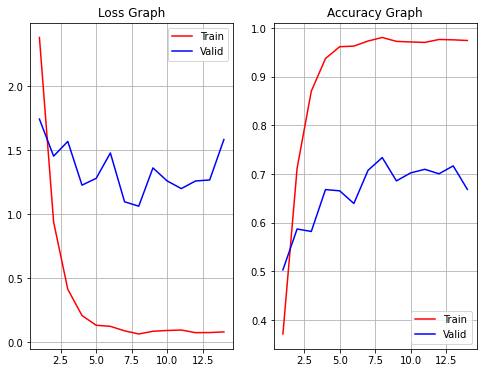

In [9]:
for tr_idx, va_idx in StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True).split(filenames, labels):
    break

tr_filenames, va_filenames, tr_labels, va_labels = filenames[tr_idx], filenames[va_idx], labels[tr_idx], labels[va_idx]

tr_labels = le.fit_transform(tr_labels)
va_labels = le.transform(va_labels)

tr_data_setup = DS("../input/sorghum-id-fgvc-9/train_images", tr_filenames, tr_labels.reshape(-1, 1), "train", TRANSFORM)
va_data_setup = DS("../input/sorghum-id-fgvc-9/train_images", va_filenames, va_labels.reshape(-1, 1), "valid", TRANSFORM)

dataloaders = {
    "train" : DL(tr_data_setup, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(SEED)),
    "valid" : DL(va_data_setup, batch_size=batch_size, shuffle=False),
}

torch.manual_seed(SEED)
model = CNN(mode=mode, model_name=model_name).to(DEVICE)
optimizer = model.get_optimizer(lr=lr, wd=wd)
scheduler = None
if isinstance(patience, int) and isinstance(eps, float):
    scheduler = get_plateau_scheduler(optimizer=optimizer, patience=patience, eps=eps)

L, A, BLE, BAE, name = fit(model=model, optimizer=optimizer, scheduler=scheduler, 
                           epochs=epochs, early_stopping_patience=early_stopping, 
                           dataloaders=dataloaders, verbose=True)

show_graphs(L, A)

### **Submission**

In [10]:
# ss_df = pd.read_csv("../input/sorghum-id-fgvc-9/sample_submission.csv")
# ts_filenames = ss_df.filename.copy().values

# ts_data_setup = DS("../input/sorghum-id-fgvc-9/test", ts_filenames, None, "test", TRANSFORM)
# ts_data = DL(ts_data_setup, batch_size=batch_size, shuffle=False)

# y_pred = predict(model=model, dataloader=ts_data, path="../saves/state.pt")

# ss_df["cultivar"] = y_pred.astype("uint8")
# ss_df.to_csv("submission.csv", index=False)